# Introduction

In this notebook, we will explore the [Heart Failure Prediction Dataset](https://www.kaggle.com/fedesoriano/heart-failure-prediction). This dataset consists of 11 clinical features (such as age, sex, cholesterol, etc.) and 1 target label, namely HeartDisease, from 918 observations (patients). The main objective is to create a model that will succesfully predict whether a person has a cardiovascular disease or not, based on these 11 clinical features. Thus, this is a binary classification problem. A machine learning model would be of great help on early detections. 

This dataset was created by combining different datasets already available independently but not combined before. In this dataset, 5 heart datasets are combined over 11 common features which makes it the largest heart disease dataset available so far for research purposes. The five datasets used for its curation are:

Cleveland: 303 observations
Hungarian: 294 observations
Switzerland: 123 observations
Long Beach VA: 200 observations
Stalog (Heart) Data Set: 270 observations
Total: 1190 observations
Duplicated: 272 observations

Final dataset: 918 observations

# Data and Libraries

In [1]:
# Import Basic Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## Loading the data
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


There are 12 features in total (including the target). Here's the detailed explanation of each feature provided with the dataset:


1. Age: Age of the patient in years
2. Sex: Gender of the patient. [M: Male, F: Female]
3. ChestPain Type: Type of chest pain[ TA: Typical Angina, ATA: Atypical Angina, NAP: Non Anginal Pain, ASY: Asymptomatic]
4. Resting BP: Resting blood pressure in units mm Hg
5. Cholesterol: Serum Cholesterol in units mm/dl
6. FastingBS: Fasting Blood Sugar 1 if FastingBS > 120 mg/dl, 0 Otherwise
7. RestingECG: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
8. MaxHR: maximum heart rate achieved [Numeric value between 60 and 202]
9. ExerciseAngina: exercise-induced angina [Y: Yes, N: No]
10. Oldpeak: oldpeak = ST [Numeric value measured in depression]
11. ST_Slope: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
12. HeartDisease: output class [1: heart disease, 0: Normal]

# Exploratory Data Analysis

The first thing we need to do, is to check if our target label is balance or unbalanced. A countplot should suffice to find out.

Amount of patients without a heart disease: 410
Amount of patients with a heart disease: 508


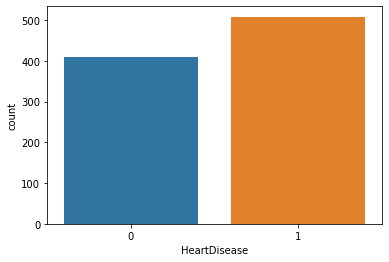

In [3]:
print('Amount of patients without a heart disease:', (df['HeartDisease']==0).sum())
print('Amount of patients with a heart disease:', (df['HeartDisease']==1).sum())

sns.countplot(data=df, x='HeartDisease');

The difference is not significant. Hence, we can assume that the target is balanced.

Let's now identify which columns are categorical, and which are numerical.

In [4]:
cat_columns = df.select_dtypes(include='object').columns.tolist()
num_columns = df.select_dtypes(exclude='object').columns.tolist()

print('The categorical columns are', cat_columns)
print('The numerical columns are', num_columns)

The categorical columns are ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
The numerical columns are ['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']


It should be noted that although FastingBS is stored as integer, since it only has two values (1 if FastingBS > 120 mg/dl, 0 otherwise), it's better if we treat it as categorical.

In [5]:
cat_columns.append('FastingBS')
num_columns.remove('FastingBS')

We'll take a look at what the distribution of the numerical columns looks like.

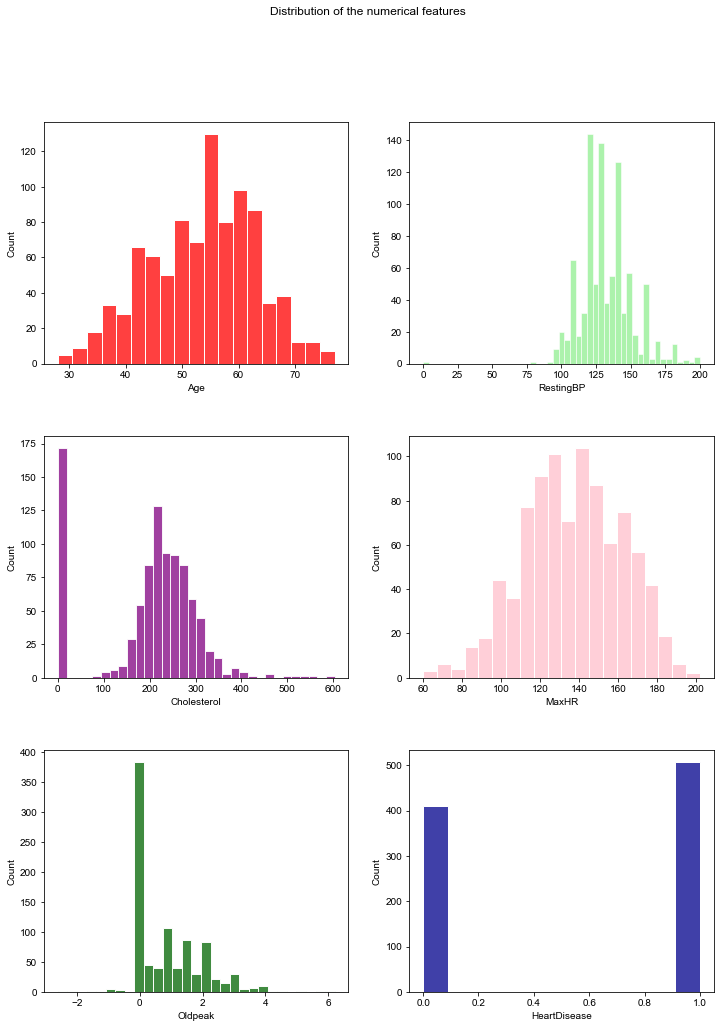

In [6]:
indexes = [ (i,j) for i in range(3) for j in range(2)]
bunch_of_colors = ['red', 'lightgreen', 'purple', 'pink', 'darkgreen', 'darkblue']

fig, axes = plt.subplots(3, 2, figsize=(12, 16))

fig.suptitle('Distribution of the numerical features')

for index, column, color in zip(indexes, df[num_columns].columns, bunch_of_colors):
    sns.set_theme()
    sns.histplot(ax=axes[index], data=df[num_columns], x=df[num_columns][column], color=color)
    
fig.subplots_adjust(hspace=.3)

There doesn't seem to be high skewness (aside from the target, clearly), so we leave these features as they are.

Let's explore a pairplot across variables based on HeartDisease.

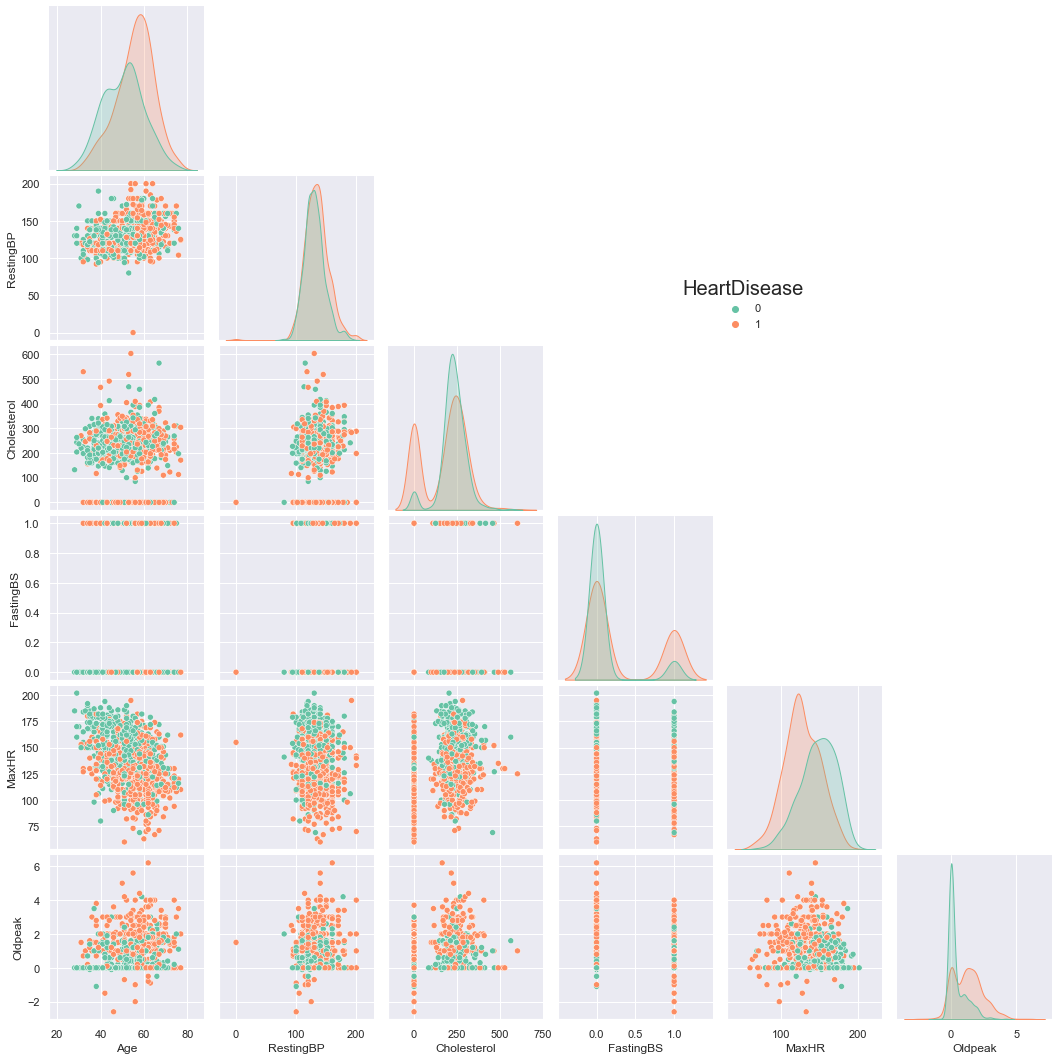

In [7]:
g = sns.pairplot(df, hue="HeartDisease", corner=True, palette = 'Set2')

g._legend.set_bbox_to_anchor((.7, .7))
g._legend.get_title().set_fontsize(20);

It seems that older people tend to be more vulnerable to heart diseases, and also people with high oldpeak (measured in depression). We check this with a pair of histplots.

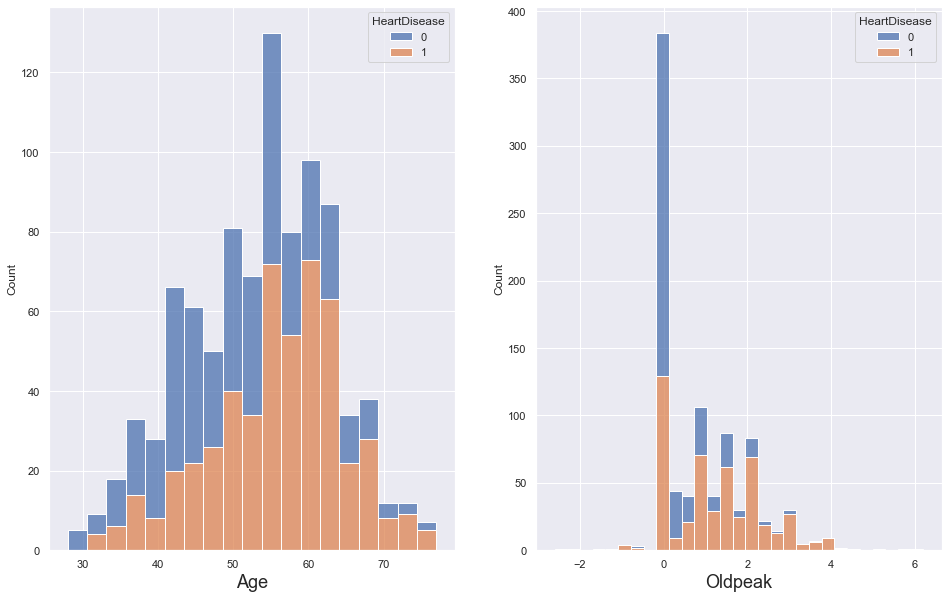

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(16, 10))

sns.histplot(ax=axes[0], data=df, x='Age', hue='HeartDisease', multiple='stack')
axes[0].set_xlabel(xlabel='Age', fontsize=18)

sns.histplot(ax=axes[1], data=df, x='Oldpeak', hue='HeartDisease', multiple='stack')
axes[1].set_xlabel(xlabel='Oldpeak', fontsize=18);

We can see that the orange ratio (when HeartDisease is equal to 1) tends to get bigger compared to the blue part the more Age and Oldpeak increase.

The scatterplots don't actually seem to reveal interesting patterns. Let's take a look at correlation numbers with a heatmap.

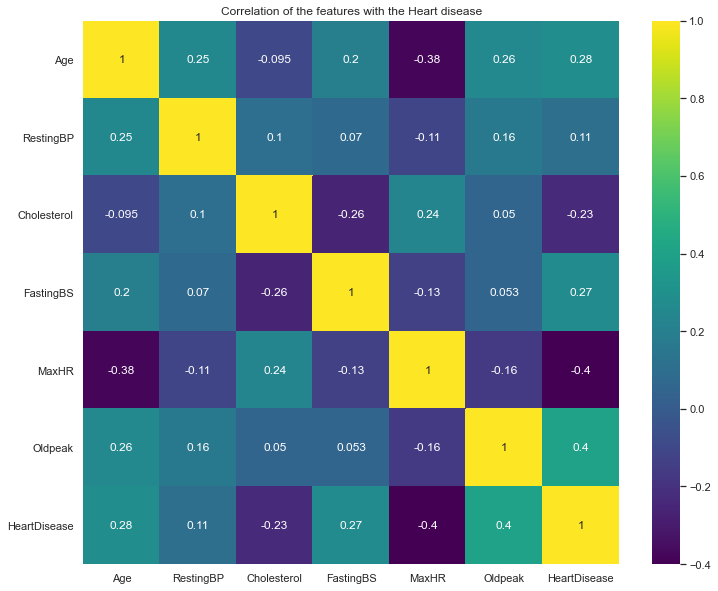

In [9]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, cmap='viridis')
plt.yticks(rotation=0)
plt.title('Correlation of the features with the Heart disease');

Pretty interesting info we find here:

1. As suspected from the pairplot, the numerical features that are more correlated to a heart disease are Age and Oldpeak (remember that this feature is related to depression, so it makes sense). Fasting Blood Sugar is also significant, but we will see about this detail clearer as categorical feature below.



2. Other numerical features don't have a significant correlation with HeartDisease. And actually, Max Heart Rate and Cholesterol have negative correlation with the target. But this is not what we're usually told by medics. A reasonable explanation is that these two features need some sort of interaction between other features in order to trigger a heart disease. 

We will now explore how the categorical features relate to the likelihood of having a heart disease.

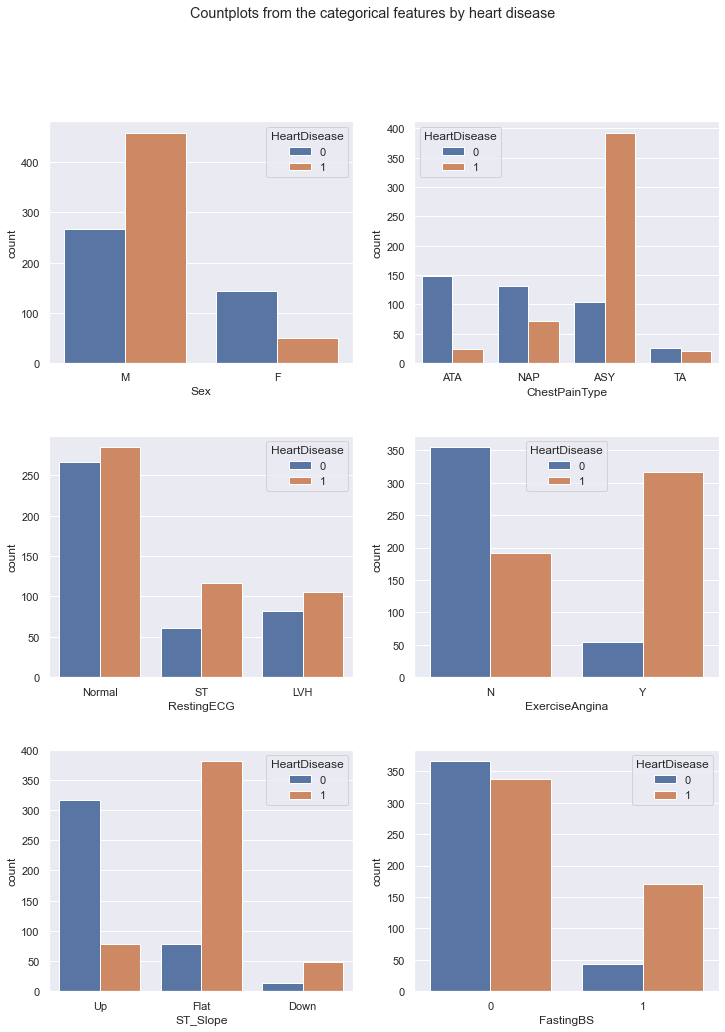

In [10]:
indexes = [ (i,j) for i in range(3) for j in range(2)]

fig, axes = plt.subplots(3, 2, figsize=(12, 16))

fig.suptitle('Countplots from the categorical features by heart disease')

for index, column in zip(indexes, df[cat_columns].columns):
    sns.countplot(ax=axes[index], data=df, x=df[cat_columns][column], hue='HeartDisease')
    
fig.subplots_adjust(hspace=.3)

The categorical features do seem to reveal having more relation to the target:

1. Men are more than twice as likely to get a heart disease than women.
2. Concerning chest pain type, it tunrs out that ASY (Asymptomatic) is the most common type among people with a heart disease.
3. Excercise induced angina with Y (Yes) is more likely to have a heart disease than N (No).
4. The slope of the peak exersice ST as flat is the most related one to the target.
5. Fasting Blood Sugar as 1 (FastingBS > 120 mg/dl) is a clear sign of potentially having a heart disease.

# Feature Engineering

Let's first prepare our data in order to train our models. In the first three models (Logistic Regression, K-Nearest Neighbors and Support Vector Machine), we will use regular train/test data as well as scaled data, such as standardized and normalized data. This will help us choose the correct kind of data for our models.

In [11]:
# Separating features from the target we want to predict
X = df.drop('HeartDisease', axis=1)
y = df['HeartDisease']

# Performing one-hot encoding for the categorical features
X = pd.get_dummies(X, drop_first=True)

We separate our data into train/test, by randomly leaving 20% of the data as a validation set. Next, we will use the standard scaler and the normal (MinMax) scaler from scikit learn to scale the train data and store these three obtained sets (with and without scaling).

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Splitting our data into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Standard scaling
scaler = StandardScaler()
st_scaled_X_train = scaler.fit_transform(X_train)
st_scaled_X_test = scaler.transform(X_test)

# Normal scaling
scaler = MinMaxScaler()
normal_scaled_X_train = scaler.fit_transform(X_train)
normal_scaled_X_test = scaler.transform(X_test)

# Storing out three types of data
X_train_datasets = [X_train, st_scaled_X_train, normal_scaled_X_train]
X_test_datasets = [X_test, st_scaled_X_test, normal_scaled_X_test]

# Model Building

## Logistic Regression

Our first model to try will be Logistic Regression. We will also test how well the Cross Validation version of the LR model performs, considering the two types of penalty L1 and L2.

Remember also that our dataset is not really unbalanced, so it might be better to just look at how good accuracy is. However, we will take into account the other common scores for classification problems, namely precision, recall and f1_score.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

# Setting up our three logistic regression models.

lr = LogisticRegression(solver='liblinear')
lr_l1 = LogisticRegressionCV(Cs=10, cv=5, penalty='l1', solver='liblinear')
lr_l2 = LogisticRegressionCV(Cs=10, cv=5, penalty='l2', solver='liblinear')

We will now fit our three models on our three separate kinds of data (without scaling, with standard scaling and normal scaling).

In [14]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

models = [lr, lr_l1, lr_l2]
precision = []
recall = []
f1_score = []
accuracy = []

for X_train_data, X_test_data in zip(X_train_datasets, X_test_datasets):
    for model in models:
        
        model.fit(X_train_data, y_train)
    
        predictions = model.predict(X_test_data)
    
        precision.append( score(y_test, predictions, average='weighted')[0] )
        recall.append( score(y_test, predictions, average='weighted')[1] )
        f1_score.append( score(y_test, predictions, average='weighted')[2] )
        accuracy.append( accuracy_score(y_test, predictions) )

Let's compare the results obtained based on the model and type of train/test data.

In [15]:
scores = [precision, recall, f1_score, accuracy]

df_lr = round(pd.DataFrame(scores, 
            index=['Precision', 'Recall', 'f1_score', 'Accuracy'],
            columns=['lr', 'lr_l1', 'lr_l2', 
                     'lr_st', 'lr_l1_st', 'lr_l2_st',
                     'lr_normal', 'lr_l1_normal', 'lr_l2_normal']), 3)

df_lr

,lr,lr_l1,lr_l2,lr_st,lr_l1_st,lr_l2_st,lr_normal,lr_l1_normal,lr_l2_normal
Precision,0.857,0.856,0.851,0.857,0.857,0.857,0.857,0.857,0.857
Recall,0.853,0.853,0.848,0.853,0.853,0.853,0.853,0.853,0.853
f1_score,0.854,0.854,0.848,0.854,0.854,0.854,0.854,0.854,0.854
Accuracy,0.853,0.853,0.848,0.853,0.853,0.853,0.853,0.853,0.853


We can see that the CV models didn't do better than the regular one, and that scaling the data didn't help either. Therefore, we simply choose and store the regular model trained on the regular data without scaling.

In [16]:
# Our chosen logistic regression model
# And trained on data without scaling

lr = LogisticRegression(solver='liblinear').fit(X_train, y_train)
predictions_lr = lr.predict(X_test)

In [17]:
# Storing the scores

df_lr = df_lr['lr'].to_frame()
df_lr

,lr
Precision,0.857
Recall,0.853
f1_score,0.854
Accuracy,0.853


## KNN

Next is the K-Nearest Neighbors model. In order to find the best K (the optimal number of neighbors), as well as what type of data (scaled or not scaled) suits our training best, we can run the following loop, 

In [18]:
from sklearn.neighbors import KNeighborsClassifier

k = 100
accuracy_k = []

for X_train_data, X_test_data in zip(X_train_datasets, X_test_datasets):
    for k in range(1, k+1):

        knn = KNeighborsClassifier(n_neighbors=k, weights='distance')
        knn = knn.fit(X_train_data, y_train)

        predictions = knn.predict(X_test_data)
        accuracy_pred = accuracy_score(y_test, predictions)

        accuracy_k.append(accuracy_pred)

Let's plot the results.

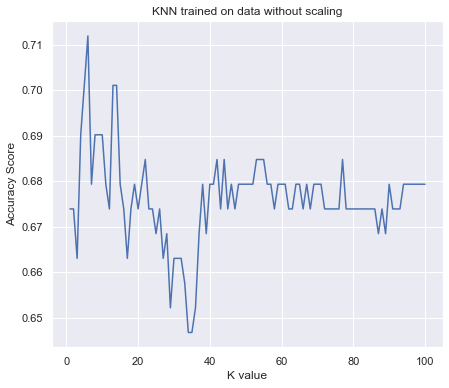

In [19]:
# Trained on data without scaling
plt.figure(figsize=(7,6))
plt.title('KNN trained on data without scaling')
plt.ylabel('Accuracy Score')
plt.xlabel('K value')
sns.lineplot(x=range(1, k+1), y=accuracy_k[:100]);

Clearly, the obtained models are pretty bad. Take a look at the best score per k:

In [20]:
print('max accuracy obtained:', round(max(accuracy_k[:100]), 3))

max accuracy obtained: 0.712


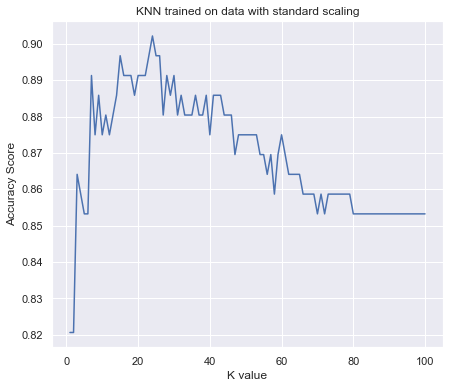

In [21]:
# Trained on data with standard scaling
plt.figure(figsize=(7,6))
plt.title('KNN trained on data with standard scaling')
plt.ylabel('Accuracy Score')
plt.xlabel('K value')
sns.lineplot(x=range(1, k+1), y=accuracy_k[100:200]);

Clearly these KNN models have performed way better on scaled data. Let's take a closer look at the peak score.

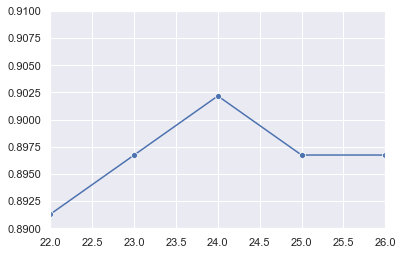

In [22]:
sns.lineplot(x=range(1, k+1), y=accuracy_k[100:200], marker='o')
plt.xlim(22,26)
plt.ylim(.89,.91);

Thus, we have found our optimal K=24. 


Let's also check the case with normal scaled data.

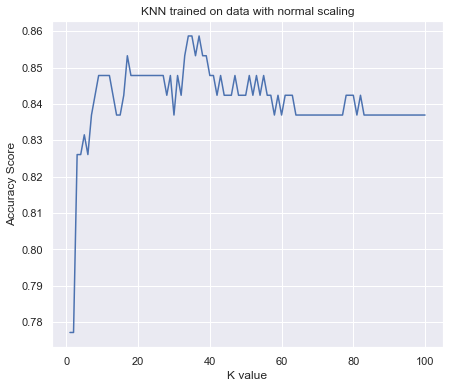

In [23]:
# Trained on data with normal scaling
plt.figure(figsize=(7,6))
plt.title('KNN trained on data with normal scaling')
plt.ylabel('Accuracy Score')
plt.xlabel('K value')
sns.lineplot(x=range(1, k+1), y=accuracy_k[200:]);

The KNN models also benefit a lot from normal scaled data, but not as well as with standard scaling. Thus, we choose our K value as 24, and we train on data with standard scaling as our best KNN model.

In [24]:
knn = KNeighborsClassifier(n_neighbors=24, weights='distance')
knn = knn.fit(st_scaled_X_train, y_train)
    
predictions_knn = knn.predict(st_scaled_X_test)

knn_scores = []

knn_scores.append( score(y_test, predictions_knn, average='weighted')[0] )
knn_scores.append( score(y_test, predictions_knn, average='weighted')[1] )
knn_scores.append( score(y_test, predictions_knn, average='weighted')[2] )
knn_scores.append( accuracy_score(y_test, predictions_knn) )

df_knn = pd.DataFrame(knn_scores, columns=['knn'],
            index=['Precision', 'Recall', 'f1_score', 'Accuracy'])

df_knn['knn'] = np.round(df_knn['knn'], 3)

df_knn

,knn
Precision,0.904
Recall,0.902
f1_score,0.902
Accuracy,0.902


## SVC

Our next model will be the Support Vector Machine Classifier. We will give the base model a try (on data with and without scaling), and then will try to tune the hyperparameters in order to find a better model.

In [25]:
from sklearn.svm import SVC

accuracy_SVC = []

for X_train_data, X_test_data in zip(X_train_datasets, X_test_datasets):
    
    svc = SVC()
    svc = svc.fit(X_train_data, y_train)
    
    predictions = svc.predict(X_test_data)
    accuracy_pred = accuracy_score(y_test, predictions)

    accuracy_SVC.append(round(accuracy_pred, 3))
    
accuracy_SVC

[0.685, 0.875, 0.848]

The SVC has a similar behaviour compared to the KNN model: The model performs pretty bad when trained on data without scaling, but does well on standard scaled data.


Let's now try to tune the model with Grid Search Cross Validation.

In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C':[0.001, 0.01, 0.1, 1.25, 1.5, 2],
             'kernel': ['linear', 'poly', 'rbf'],
             'degree': [1,2,3,4],
             'gamma': ['scale', 'auto']}

svc = SVC()
grid_model = GridSearchCV(svc, param_grid, scoring='accuracy', n_jobs=-1)

grid_model.fit(st_scaled_X_train, y_train)

grid_model.best_params_

{'C': 0.1, 'degree': 1, 'gamma': 'scale', 'kernel': 'linear'}

In [27]:
print('Accuracy with grid model:', round(accuracy_score(y_test, grid_model.predict(st_scaled_X_test)), 3))

Accuracy with grid model: 0.859


Unfortunately, tuning the model didn't have a great impact on performance. Thus, we choose the base SVC model for our predictions.

In [28]:
svc = SVC()
svc = svc.fit(st_scaled_X_train, y_train)
    
predictions_svc = svc.predict(st_scaled_X_test)

svc_scores = []

svc_scores.append( score(y_test, predictions_svc, average='weighted')[0] )
svc_scores.append( score(y_test, predictions_svc, average='weighted')[1] )
svc_scores.append( score(y_test, predictions_svc, average='weighted')[2] )
svc_scores.append( accuracy_score(y_test, predictions_svc) )

df_svc = pd.DataFrame(svc_scores, columns=['svc'],
            index=['Precision', 'Recall', 'f1_score', 'Accuracy'])

df_svc['svc'] = np.round(df_svc['svc'], 3)

df_svc

,svc
Precision,0.876
Recall,0.875
f1_score,0.875
Accuracy,0.875


## Random Forest

As it is well known, we don't need to scale the data to train random forests models. So we will go with regular data without scaling.

We will try with several number of trees to find the best Random Forest model. We will keep track on the out-of-bag error as well as the accuracy on the test data.

In [29]:
from sklearn.ensemble import RandomForestClassifier

RF = RandomForestClassifier(oob_score=True, 
                            random_state=42, 
                            warm_start=True,
                            n_jobs=-1)

oob_list = list()
accuracy_scores = []
list_of_trees = [15, 20, 30, 40, 50, 100, 150, 200, 300, 400, 500]

for n_trees in list_of_trees:
    
    RF.set_params(n_estimators=n_trees)
    RF.fit(X_train, y_train)

    oob_error = 1 - RF.oob_score_
    
    predictions = RF.predict(X_test)
    accuracy_pred = accuracy_score(y_test, predictions)
    accuracy_scores.append(accuracy_pred)
    
    oob_list.append(pd.Series({'n_trees': n_trees, 'oob_error': oob_error}))

rf_oob_df = pd.concat(oob_list, axis=1).T.set_index('n_trees')

rf_oob_df['accuracy'] = accuracy_scores
rf_oob_df

C:\Users\Victor\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:541: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\Victor\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:545: RuntimeWarning: invalid value encountered in true_divide
  decision = (predictions[k] /


,oob_error,accuracy
n_trees,,
15.0,0.185286,0.836957
20.0,0.181199,0.847826
30.0,0.166213,0.864130
40.0,0.160763,0.864130
50.0,0.162125,0.858696
100.0,0.148501,0.875000
150.0,0.143052,0.875000
200.0,0.140327,0.864130
300.0,0.137602,0.864130


Let's take a look at both the oob_error, as well as the accuracy scores obtained by the number of trees.

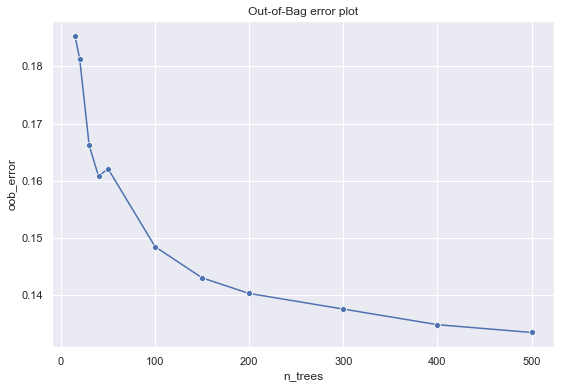

In [30]:
# oob error
plt.figure(figsize=(9,6))
plt.title('Out-of-Bag error plot')
plt.xlabel('n_trees')
sns.lineplot(data=rf_oob_df, x=list_of_trees, y='oob_error', marker='o');

The oob_error consistently goes down as the number of trees increases. Let's see how the accuracy behaves.

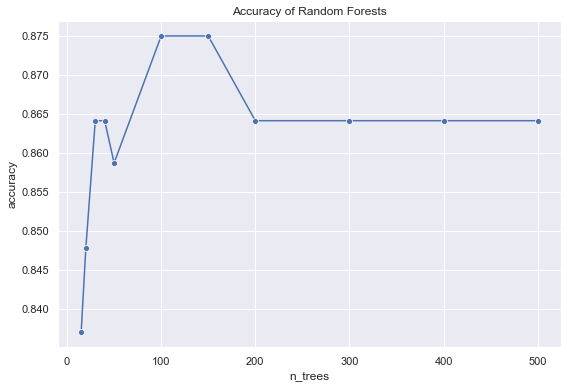

In [31]:
# accuracy scores
plt.figure(figsize=(9,6))
plt.title('Accuracy of Random Forests')
plt.xlabel('n_trees')
sns.lineplot(data=rf_oob_df, x=list_of_trees, y='accuracy', marker='o');

We choose the Random Forest model with n_trees=100.

In [32]:
rf = RF.set_params(n_estimators=100, warm_start=False)
rf = rf.fit(X_train, y_train)
    
predictions_rf = rf.predict(X_test)

rf_scores = []

rf_scores.append( score(y_test, predictions_rf, average='weighted')[0] )
rf_scores.append( score(y_test, predictions_rf, average='weighted')[1] )
rf_scores.append( score(y_test, predictions_rf, average='weighted')[2] )
rf_scores.append( accuracy_score(y_test, predictions_rf) )

df_rf = pd.DataFrame(rf_scores, columns=['rf'],
            index=['Precision', 'Recall', 'f1_score', 'Accuracy'])

df_rf['rf'] = np.round(df_rf['rf'], 3)

df_rf

,rf
Precision,0.875
Recall,0.875
f1_score,0.875
Accuracy,0.875


## Gradient Boosting

Finally, our last model is the Gradient Boosting, which is based on Random Forests. Thus, again, we don't need to worry about scaling the data.

As we did with RF, we try several number of trees to find the best one.

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

error_list = list()
tree_list = [15, 20, 30, 40, 50, 100, 150, 200, 300, 400]

for n_trees in tree_list:

    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)
    GBC.fit(X_train, y_train)
    
    y_pred_gb = GBC.predict(X_test)

    error = 1.0 - accuracy_score(y_test, y_pred_gb)
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df_gb = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df_gb

,error
n_trees,
15.0,0.135870
20.0,0.130435
30.0,0.125000
40.0,0.125000
50.0,0.130435
100.0,0.135870
150.0,0.125000
200.0,0.130435
300.0,0.130435


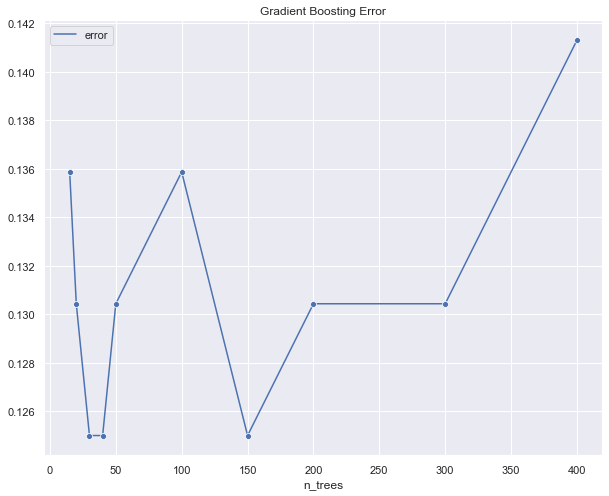

In [34]:
# Plotting the error
plt.figure(figsize=(10,8))
plt.title('Gradient Boosting Error')
sns.lineplot(data=error_df_gb, marker='o');

It seems like a good choice to set n_trees=30. So let's store these results.

In [35]:
gb= GradientBoostingClassifier(n_estimators=30, random_state=42)
gb = gb.fit(X_train, y_train)
    
predictions_gb = gb.predict(X_test)

gb_scores = []

gb_scores.append( score(y_test, predictions_gb, average='weighted')[0] )
gb_scores.append( score(y_test, predictions_gb, average='weighted')[1] )
gb_scores.append( score(y_test, predictions_gb, average='weighted')[2] )
gb_scores.append( accuracy_score(y_test, predictions_gb) )

df_gb = pd.DataFrame(gb_scores, columns=['gb'],
            index=['Precision', 'Recall', 'f1_score', 'Accuracy'])

df_gb['gb'] = np.round(df_gb['gb'], 3)

df_gb

,gb
Precision,0.875
Recall,0.875
f1_score,0.875
Accuracy,0.875


# Model Evaluation

It's time to see the results from our models. For each one of them, we'll take a look at their classification reports, confusion matrix and the number of false positives and false negatives.

In [36]:
from sklearn.metrics import plot_confusion_matrix, classification_report

## Logistic Regression report

In [37]:
# Logistic Regression classification report
print(classification_report(y_test, predictions_lr))

              precision    recall  f1-score   support

           0       0.80      0.87      0.83        77
           1       0.90      0.84      0.87       107

    accuracy                           0.85       184
   macro avg       0.85      0.86      0.85       184
weighted avg       0.86      0.85      0.85       184



In [38]:
sns.set_theme(style="white")

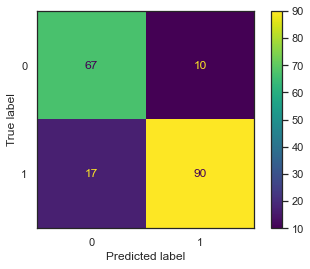

In [39]:
# Logistic Regression confusion matrix
plot_confusion_matrix(lr, X_test, y_test);

- We obtained 10 false positives out of 77 true negatives.
- We obtained 17 false negatives out of 107 true positives.

## KNN report

In [40]:
# KNN classification report
print(classification_report(y_test, predictions_knn))

              precision    recall  f1-score   support

           0       0.86      0.91      0.89        77
           1       0.93      0.90      0.91       107

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



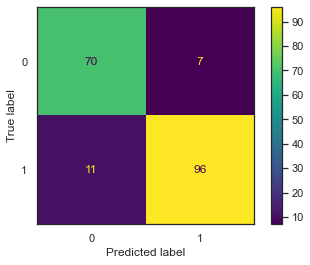

In [41]:
# KNN confusion matrix
plot_confusion_matrix(knn, st_scaled_X_test, y_test);

- We obtained 7 false positives out of 77 true negatives.
- We obtained 11 false negatives out of 107 true positives.

## SVC report

In [42]:
# SVC classification report
print(classification_report(y_test, predictions_svc))

              precision    recall  f1-score   support

           0       0.84      0.87      0.85        77
           1       0.90      0.88      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



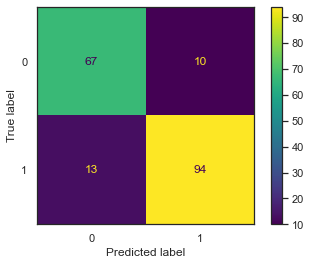

In [43]:
# SVC confusion matrix
plot_confusion_matrix(svc, st_scaled_X_test, y_test);

- We obtained 10 false positives out of 77 true negatives.
- We obtained 13 false negatives out of 107 true positives.

## Random Forest report

In [44]:
# Random Forest
print(classification_report(y_test, predictions_rf))

              precision    recall  f1-score   support

           0       0.85      0.86      0.85        77
           1       0.90      0.89      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.88      0.88      0.88       184



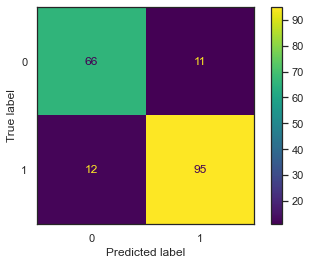

In [45]:
# Random Forest confusion matrix
plot_confusion_matrix(rf, X_test, y_test);

- We obtained 11 false positives out of 77 true negatives.
- We obtained 12 false negatives out of 107 true positives.

## Gradient Boosting report

In [46]:
# Gradient Boosting report
print(classification_report(y_test, predictions_gb))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85        77
           1       0.89      0.90      0.89       107

    accuracy                           0.88       184
   macro avg       0.87      0.87      0.87       184
weighted avg       0.87      0.88      0.87       184



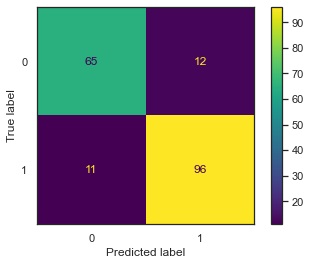

In [47]:
# Gradient Boosting confusion matrix
plot_confusion_matrix(gb, X_test, y_test);

- We obtained 12 false positives out of 77 true negatives.
- We obtained 11 false negatives out of 107 true positives.

# Final Comments

In [48]:
pd.concat((df_lr, df_knn, df_svc, df_rf, df_gb), axis=1)

,lr,knn,svc,rf,gb
Precision,0.857,0.904,0.876,0.875,0.875
Recall,0.853,0.902,0.875,0.875,0.875
f1_score,0.854,0.902,0.875,0.875,0.875
Accuracy,0.853,0.902,0.875,0.875,0.875


As we can see, all of our models obtained decent results. The Logistic Regression model performed slightly worse than the others, and the Support Vector Classifier, Random Forest and Gradient Boosting got exactly the same scores, but with slight differences with False Positives/Negatives. Finally, the KNN model performed best, reaching 90% accuracy which is impressive.

To finish this notebook, we can also take a look at the feature importance of both Random Forest and Gradient Boosting.

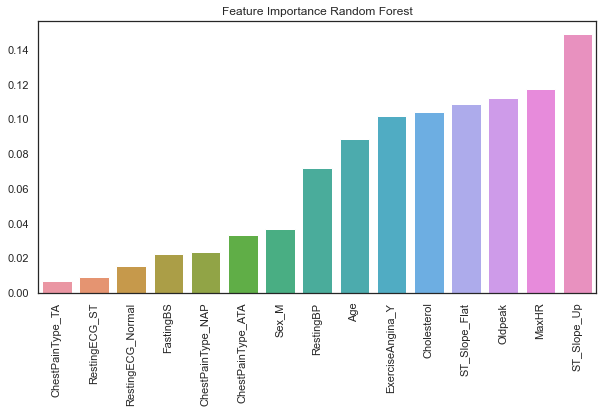

In [49]:
rf_feature = pd.DataFrame(index=X.columns, data=rf.feature_importances_).sort_values(0)

plt.figure(figsize=(10,5))
sns.barplot(data=rf_feature, x=rf_feature.index.values, y=rf_feature[0].values)
plt.title('Feature Importance Random Forest')
plt.xticks(rotation=90);

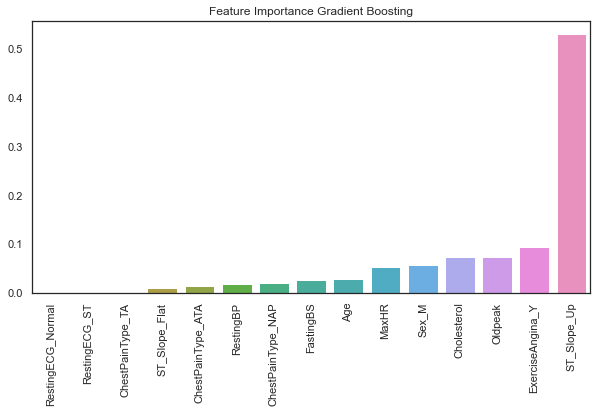

In [50]:
gb_feature = pd.DataFrame(index=X.columns, data=gb.feature_importances_).sort_values(0)

plt.figure(figsize=(10,5))
sns.barplot(data=gb_feature, x=gb_feature.index.values, y=gb_feature[0].values)
plt.title('Feature Importance Gradient Boosting')
plt.xticks(rotation=90);

Both the models have considered the ST Slope (with Up:Upsloping) as their most important feature. Several other features have obtained high importance, such as Oldpeak, Sex_M (Masculine) and Cholesterol.